In [1]:
# This file was edited on October 6, 2018 by Takenori Shimamura
# Here are libraries 
import numpy as np
import numpy.random as random
from numpy import nan as NA
import scipy as sp
from scipy import interpolate
from pandas import Series, DataFrame
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
%precision 20

'%.20f'

In [2]:
ls

00Failure/
20190307RepeatableSpline.ipynb
20190331CylindricalLensProfile_20190330Scan17.csv
20190331ResidueMirrorAndCyl_MA-0.05mmMT-0.002Offset500nm.csv
20190331ResidueMirrorAndCyl_MA-0.05mmMT-0.002Offset500nm.txt
20190331ResidueMirrorAndCyl_MA-0.05mmMT-0.002Offset550nm.csv
20190331ResidueMirrorAndCyl_MA-0.05mmMT-0.002Offset600nm.csv
20190331ResidueMirrorAndCyl_MA-0.05mmMT-0.002Offset650nm.csv
20190331SputerYieldon20190331.txt
20190331SputterYield_20190330Scan10.csv
20190331SputterYield_20190330Scan11.csv
20190331SputterYield_20190330Scan12.csv
20190331_RectSputterYieldProfile_20190330.xlsx


In [3]:
# mirror parameters
workdis    = (1.0+1.0) # workdistance in mm
Ldis       = 5.6 * 1000 - workdis # the distance between the light source and the mirror center
inci_ang   = 0.025 # the glancing angle at the center of the mirror in rad
mir_length = 2.2 # the length of the mirror in mm

# parameters for this sourcecode
N = 10000
N_sample = int(mir_length /  (0.5 / 1000))
cyl_radius = 169.46
#filename = ['20180905_2.5XCenter(29444, 17)_ave8.csv']
filename = ['20190331CylindricalLensProfile_20190330Scan17.csv']
mir_vert_trans = 600.0 # in nm
sputter_offset = 450.0 # in nm
mir_adjust = [-0.05] # in mm
mir_tilt = -0.002

# some useful variables
constB = workdis / Ldis
costheta = np.cos(inci_ang)
cos2theta = np.cos(2.0 * inci_ang)
sin2theta = np.sin(2.0 * inci_ang)
tanincidnet = np.tan(inci_ang)

relatA = (1.0 + constB) * np.sqrt(1.0 + np.sqrt(1.0 - np.power(sin2theta * (1.0 - constB) / (1.0 + constB), 2.0))) / (np.sqrt(8.0) * costheta)
relatB = np.sqrt(relatA * relatA - (1.0 + constB) * (1.0 + constB) / 4.0)
relatP = (1.0 - constB) / 2.0
mir_center = Ldis * relatP
a = Ldis * relatA
b = Ldis * relatB
c = np.sqrt(a * a - b * b)

def MirFunc(x): # in mm
    return b * np.sqrt(1 - x * x / (a * a)) 
def CylFunc(x): # in nm
    x_shift = x - 17 / 1000 # in mm
    return (cyl_radius - np.sqrt(cyl_radius * cyl_radius - x_shift * x_shift)) * 1000 * 1000 - 180

In [4]:
# Create data of the ideal mirror shape
mir_pos = np.array([mir_length / N * i - 0.5*mir_length for i in range(N)])
mir_shape_ideal = pd.DataFrame([mir_pos, MirFunc(mir_pos + Ldis - c) - MirFunc(Ldis - c)]).T
mir_shape_ideal = mir_shape_ideal.rename(columns={0: 'x', 1: 'y'})
mir_shape_ideal.head()

,x,y
0,-1.10000,0.024485
1,-1.09978,0.024480
2,-1.09956,0.024476
3,-1.09934,0.024471
4,-1.09912,0.024467


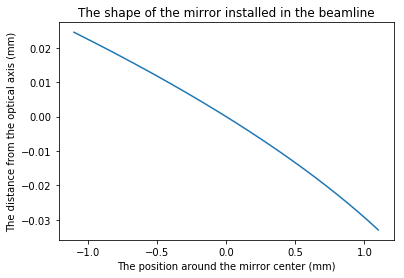

In [5]:
plt.plot(mir_shape_ideal['x'], mir_shape_ideal['y'])
plt.title("The shape of the mirror installed in the beamline")
plt.ylabel("The distance from the optical axis (mm)")
plt.xlabel("The position around the mirror center (mm)")
plt.show()

In [6]:
gap_y = mir_shape_ideal['y'][N-1] - mir_shape_ideal['y'][0]
gap_x = mir_shape_ideal['x'][N-1] - mir_shape_ideal['x'][0]
gap_opp = np.sqrt(gap_x * gap_x + gap_y * gap_y)
tmp_rot_cos = gap_y / gap_opp
tmp_rot_sin = gap_x / gap_opp
rot_cos = tmp_rot_cos * np.cos(mir_tilt) - tmp_rot_sin * np.sin(mir_tilt)
rot_sin = tmp_rot_sin * np.cos(mir_tilt) + tmp_rot_cos * np.sin(mir_tilt)
temp_y = mir_shape_ideal['x'] * rot_cos - mir_shape_ideal['y'] * rot_sin
temp_x = mir_shape_ideal['x'] * rot_sin + mir_shape_ideal['y'] * rot_cos
mir_surface_ideal = pd.DataFrame([temp_x, temp_y]).T
mir_surface_ideal

,0,1
0,-1.100271,0.002005
1,-1.100051,0.002004
2,-1.099831,0.002003
3,-1.099611,0.002003
4,-1.099390,0.002002
5,-1.099170,0.002001
6,-1.098950,0.002000
7,-1.098730,0.001999
8,-1.098510,0.001998
9,-1.098290,0.001997


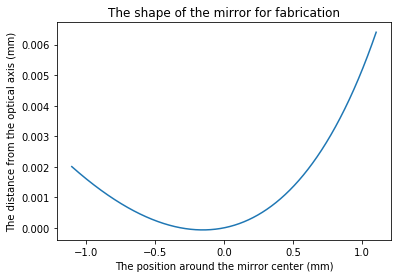

In [7]:
plt.plot(mir_surface_ideal[0], mir_surface_ideal[1])
plt.title("The shape of the mirror for fabrication")
plt.ylabel("The distance from the optical axis (mm)")
plt.xlabel("The position around the mirror center (mm)")
plt.show()

In [8]:
# Calculate the point with the minimum value, so that the experimental data can refer to it
theor_mir_dip = mir_surface_ideal[0][mir_surface_ideal[1].idxmin()]
theor_mir_dip

-0.15316603192633734820

In [9]:
mir_surface_ideal[1] = mir_surface_ideal[1] - mir_surface_ideal[1].min()

In [10]:
ls

00Failure/
20190307RepeatableSpline.ipynb
20190331CylindricalLensProfile_20190330Scan17.csv
20190331ResidueMirrorAndCyl_MA-0.05mmMT-0.002Offset500nm.csv
20190331ResidueMirrorAndCyl_MA-0.05mmMT-0.002Offset500nm.txt
20190331ResidueMirrorAndCyl_MA-0.05mmMT-0.002Offset550nm.csv
20190331ResidueMirrorAndCyl_MA-0.05mmMT-0.002Offset600nm.csv
20190331ResidueMirrorAndCyl_MA-0.05mmMT-0.002Offset650nm.csv
20190331SputerYieldon20190331.txt
20190331SputterYield_20190330Scan10.csv
20190331SputterYield_20190330Scan11.csv
20190331SputterYield_20190330Scan12.csv
20190331_RectSputterYieldProfile_20190330.xlsx


In [11]:
len(filename)

1

In [12]:
# Set the name of columns and import csv file
col_names = [ 'c{0:02d}'.format(i) for i in range(4 * len(filename)) ]
mir_surface_after = pd.DataFrame([])
for i in range(len(filename)):
    mir_surface_after = pd.concat([mir_surface_after, pd.read_csv(filename[i], sep=',', names=col_names[4*i:4*(i+1)])], axis = 1)
mir_surface_after.head()

,c00,c01,c02,c03
0,Surface Profile,NaN,NaN,NaN
1,Profile Plot Data,NaN,NaN,NaN
2,Distance (mm) #1,Height (nm) #1,Distance (mm) #2,Height (nm) #2
3,0.000,-1272.994,0.000,NO_DATA
4,0.006,-1273.263,0.006,NO_DATA


In [13]:
drop_ids = [0, 1, 2]
mir_surface_after_proc = mir_surface_after.drop(drop_ids, axis = 0)
for column in col_names:
    mir_surface_after_proc[column] = mir_surface_after_proc[column].replace("NO_DATA", NA)
    mir_surface_after_proc[column] = pd.to_numeric(mir_surface_after_proc[column].str.strip())

In [14]:
# Create DataFrame only for short data
col_namess = [col_names[i] for i in range(len(col_names)) if (i % 4 == 0) or (i % 4 == 1)]
mir_surface_after_procs = pd.DataFrame([])
for i in range(int(len(col_namess)/2)):
    columns = col_namess[2*i: 2*(i+1)]
    mir_surface_after_procs = pd.concat([mir_surface_after_procs, mir_surface_after_proc[columns].dropna()], axis = 1)

# Create DataFrame only for long data
col_namesl = [col_names[i] for i in range(len(col_names)) if (i % 4 == 2) or (i % 4 == 3)]
mir_surface_after_procl = pd.DataFrame([])
for i in range(int(len(col_namesl)/2)):
    columns = col_namesl[2*i: 2*(i+1)]
    mir_surface_after_procl = pd.concat([mir_surface_after_procl, mir_surface_after_proc[columns].dropna()], axis = 1) 

In [15]:
# Reverse the position on the figure
mir_surface_after_procl.c02 = -1.0 * (mir_surface_after_procl.c02 - mir_surface_after_procl.c02.max())
#mir_surface_after_procl.c00 = -1.0 * (mir_surface_after_procl.c00 - mir_surface_after_procl.c00.max())
#mir_surface_after_procl.c04 = -1.0 * (mir_surface_after_procl.c04 - mir_surface_after_procl.c04.max())
#mir_surface_after_procl.c08 = -1.0 * (mir_surface_after_procl.c08 - mir_surface_after_procl.c08.max())

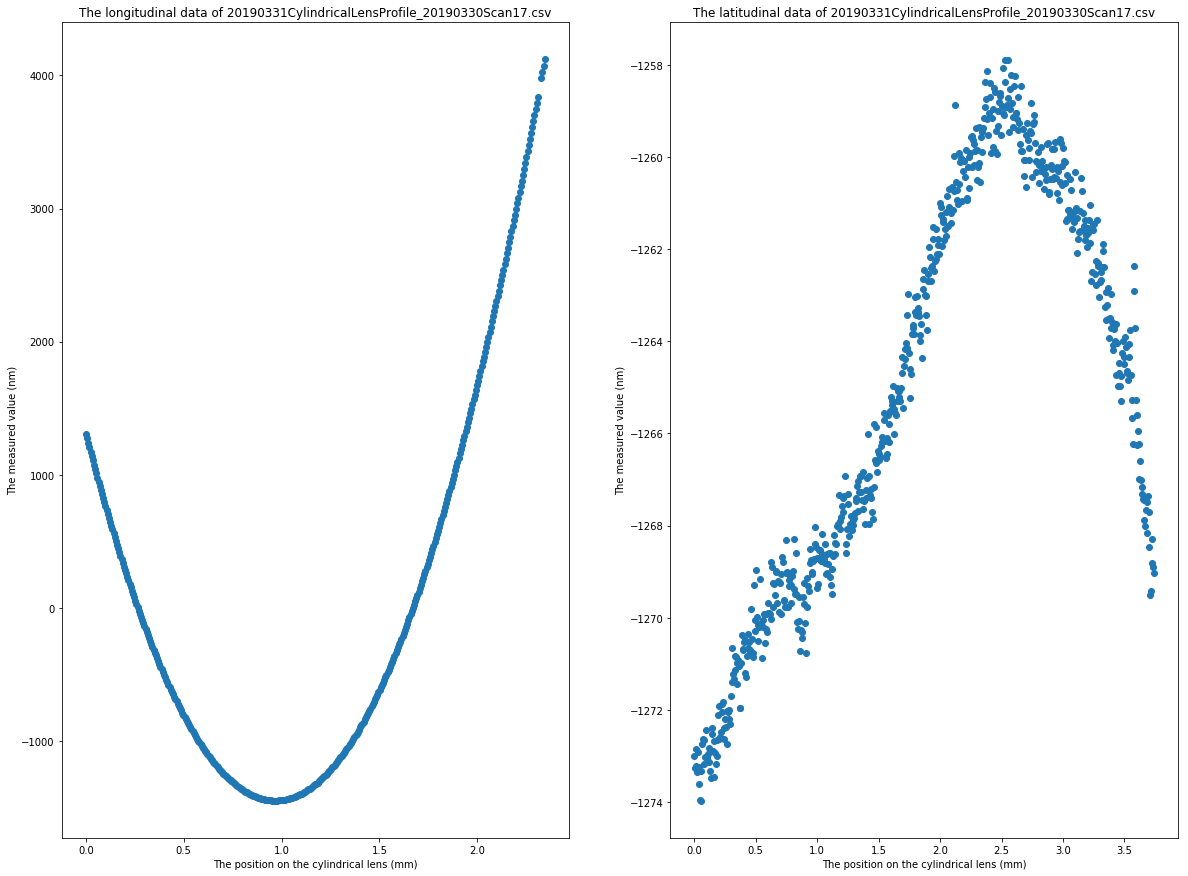

In [16]:
plt.figure(figsize=(20, 15))
plt.rcParams["font.size"] = 10
for i in range(len(filename)):
    plt.subplot(len(filename),2,i*2 + 1)
    plt.scatter(mir_surface_after_procl[col_namesl[2*i]], mir_surface_after_procl[col_namesl[2*i+1]])
    plt.title("The longitudinal data of {}".format(filename[i]))
    plt.xlabel("The position on the cylindrical lens (mm)")
    plt.ylabel("The measured value (nm)")

    plt.subplot(len(filename),2,i*2 + 2)
    plt.scatter(mir_surface_after_procs[col_namess[2*i]], mir_surface_after_procs[col_namess[2*i+1]])
    plt.title("The latitudinal data of {}".format(filename[i]))
    plt.xlabel("The position on the cylindrical lens (mm)")
    plt.ylabel("The measured value (nm)")
plt.show()

In [17]:
# Create the profile of the original cylindrical lens
cyl_surface = pd.DataFrame([mir_surface_ideal[0], CylFunc(mir_surface_ideal[0])], index=['x','y']).T
cyl_surface.head()

,x,y
0,-1.100271,3503.191439
1,-1.100051,3501.740783
2,-1.099831,3500.290413
3,-1.099611,3498.840328
4,-1.099390,3497.390529


In [18]:
# Adjust all data for the figures by subtracting the background
for i in range(int(len(col_namesl)/2)):
    mir_surface_after_procl[col_namesl[i*2+1]] = mir_surface_after_procl[col_namesl[i*2+1]] - mir_surface_after_procl[col_namesl[i*2+1]].min()
    expt_mir_dip = mir_surface_after_procl[col_namesl[i*2]][mir_surface_after_procl[col_namesl[i*2+1]].idxmin()]
    mir_surface_after_procl[col_namesl[i*2]] = mir_surface_after_procl[col_namesl[i*2]] - expt_mir_dip + theor_mir_dip + mir_adjust[i]
mir_surface_ideal[1] = mir_surface_ideal[1] * 1000 * 1000
expt_mir_dip

0.96700000000000030376

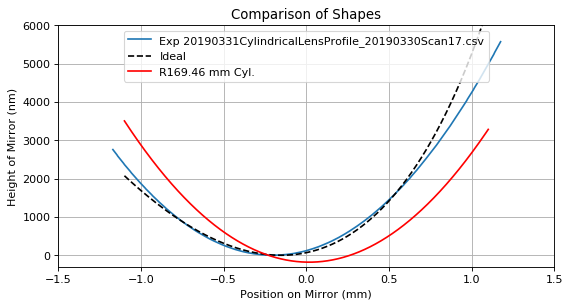

In [19]:
plt.figure(figsize=(8, 4), dpi=80)
plt.rcParams["font.size"] = 10
for i in range(len(filename)):
    plt.plot(mir_surface_after_procl[col_namesl[i*2]], mir_surface_after_procl[col_namesl[i*2+1]], '-', label="Exp {}".format(filename[i]))
plt.plot(mir_surface_ideal[0], mir_surface_ideal[1], '--', color='black',label="Ideal")
plt.plot(cyl_surface.x, cyl_surface.y, color='r',label = "R{} mm Cyl.".format(cyl_radius))
plt.xlim([-1.5, 1.5])
plt.ylim([-300,6000])
plt.title("Comparison of Shapes")
plt.xlabel("Position on Mirror (mm)")
plt.ylabel("Height of Mirror (nm)")
plt.legend(loc = 'upper center')
plt.grid(True)
plt.show()

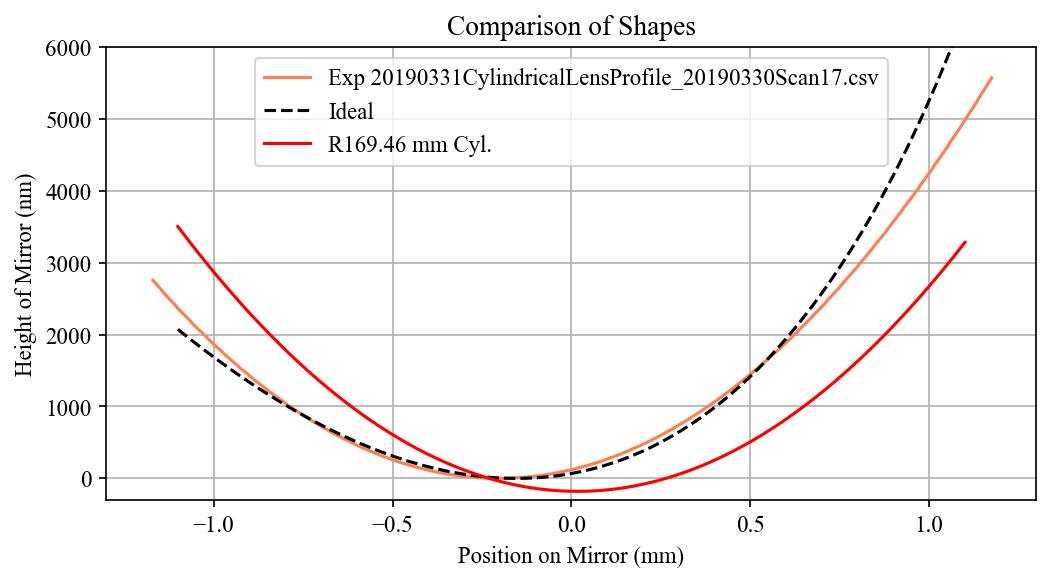

-1.17016603192633761310

In [20]:
plt.figure(figsize=(8, 4), dpi=150)
plt.rcParams["font.size"] = 11
plt.rcParams['font.family'] = 'Times New Roman'
i = 0
plt.plot(mir_surface_after_procl[col_namesl[i*2]], mir_surface_after_procl[col_namesl[i*2+1]], '-', color='coral',label="Exp {}".format(filename[i]))
i = 1
#plt.plot(mir_surface_after_procl[col_namesl[i*2]], mir_surface_after_procl[col_namesl[i*2+1]], '-', color='b',label="Exp {}".format(filename[i]))
i = 2
#plt.plot(mir_surface_after_procl[col_namesl[i*2]], mir_surface_after_procl[col_namesl[i*2+1]], '-', color='g',label="Exp {}".format(filename[i]))


plt.plot(mir_surface_ideal[0], mir_surface_ideal[1], '--', color='black',label="Ideal")
plt.plot(cyl_surface.x, cyl_surface.y, color='red',label = "R{} mm Cyl.".format(cyl_radius))
plt.xlim([-1.3, 1.3])
plt.ylim([-300,6000])
plt.title("Comparison of Shapes")
plt.xlabel("Position on Mirror (mm)")
plt.ylabel("Height of Mirror (nm)")
plt.legend(loc = 'upper center')
plt.grid(True)
plt.show()
min(mir_surface_after_procl[col_namesl[0*2]])

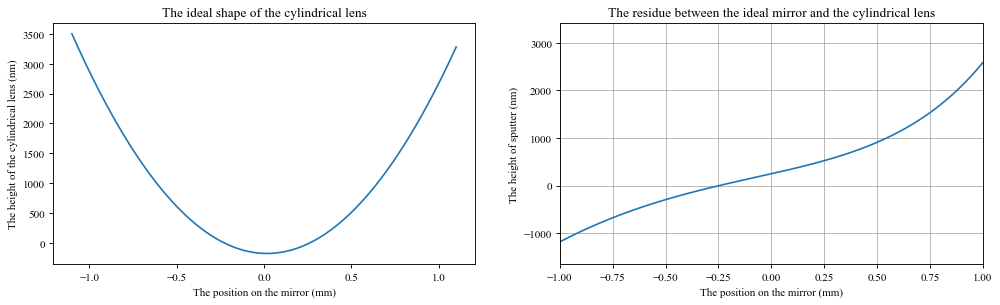

In [21]:
# Calculate the residue between the ideal and the shape of a cylindrical lens
mir_residue0 = pd.DataFrame([mir_surface_ideal[0], mir_surface_ideal[1] - cyl_surface.y], index=['x', 'y']).T
plt.figure(figsize=(15, 4), dpi=80)
plt.rcParams["font.size"] = 10
plt.subplot(1,2,1)
plt.plot(mir_surface_ideal[0], CylFunc(mir_surface_ideal[0]))
plt.title("The ideal shape of the cylindrical lens")
plt.xlabel("The position on the mirror (mm)")
plt.ylabel("The height of the cylindrical lens (nm)")

plt.subplot(1,2,2)
plt.plot(mir_residue0.x, mir_residue0.y)
plt.xlim([-1, 1])
plt.title("The residue between the ideal mirror and the cylindrical lens")
plt.xlabel("The position on the mirror (mm)")
plt.ylabel("The height of sputter (nm)")
plt.grid(True)



In [22]:
# Calculate the residue between the ideal and the experimental data

SplineSurface = [interpolate.interp1d(mir_surface_after_procl[col_namesl[2*i]], mir_surface_after_procl[col_namesl[2*i+1]], 'cubic') for i in range(len(filename))]
mir_residue = pd.DataFrame([])
for i in range(len(filename)):
    mir_residue = pd.concat([mir_residue, pd.DataFrame([mir_surface_ideal[0], mir_surface_ideal[1] - SplineSurface[i](mir_surface_ideal[0])], index=['x{}'.format(i), 'y{}'.format(i)]).T], axis=1)
mir_residue.head()

,x0,y0
0,-1.100271,-292.279739
1,-1.100051,-291.884987
2,-1.099831,-291.510384
3,-1.099611,-291.154998
4,-1.099390,-290.817848


In [23]:
#plt.plot(mir_surface_ideal[0],SplineSurface[1](mir_surface_ideal[0]))

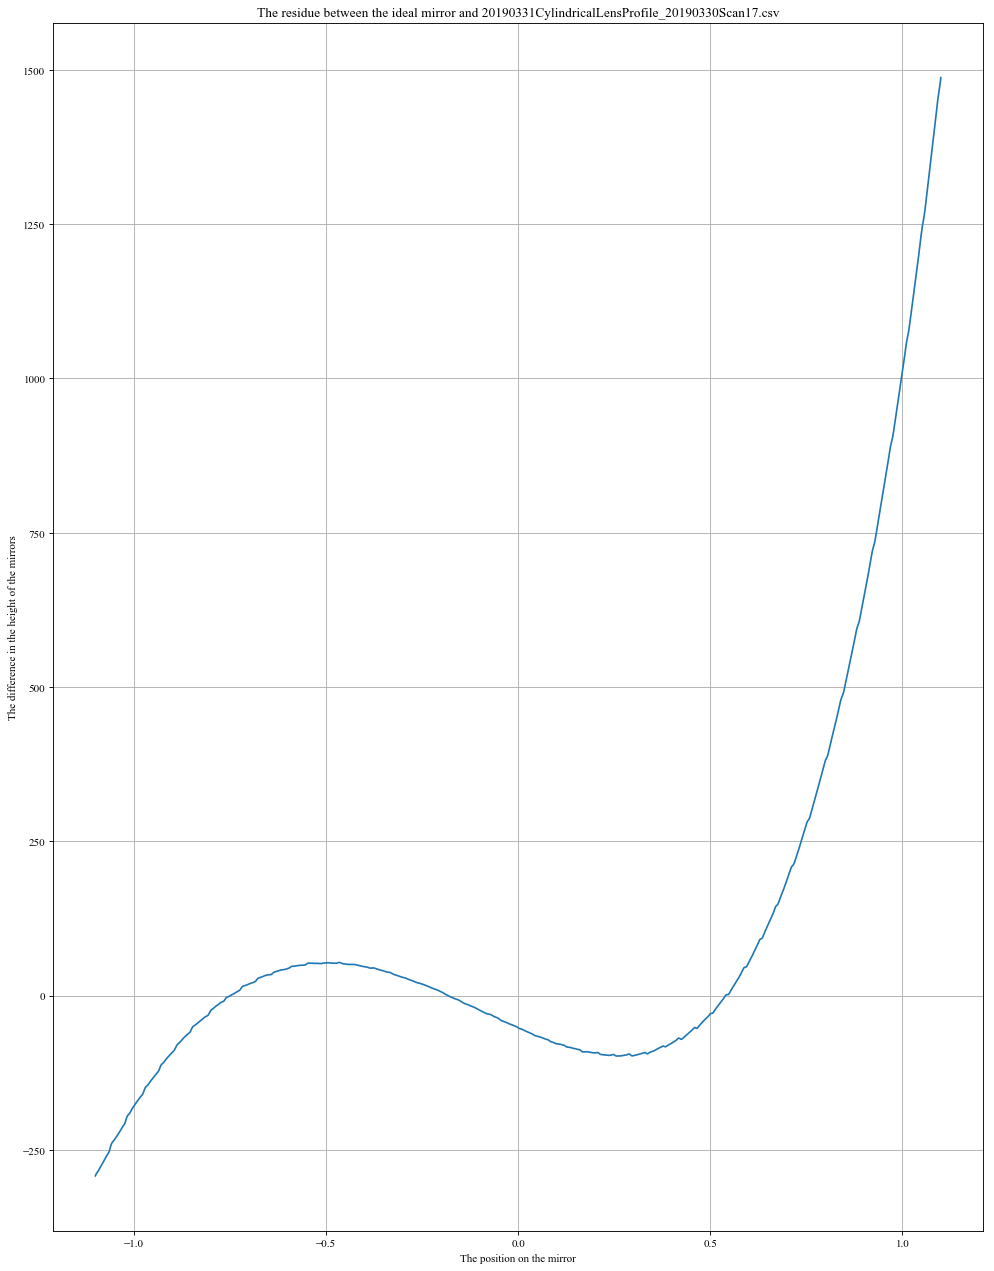

In [24]:
plt.figure(figsize=(15, 20), dpi=80)
plt.rcParams["font.size"] = 10
for i in range(len(filename)):
    plt.subplot(len(filename),1,i+1)
    x_i = "x{}".format(i)
    y_i = "y{}".format(i)
    plt.plot(mir_residue[x_i], mir_residue[y_i])
    plt.title("The residue between the ideal mirror and {}".format(filename[i]))
    plt.xlabel("The position on the mirror")
    plt.ylabel("The difference in the height of the mirrors")
    plt.grid(True)

In [25]:
SplineResidue = [interpolate.interp1d(mir_residue["x{}".format(i)], mir_residue["y{}".format(i)], 'cubic') for i in range(len(filename))]

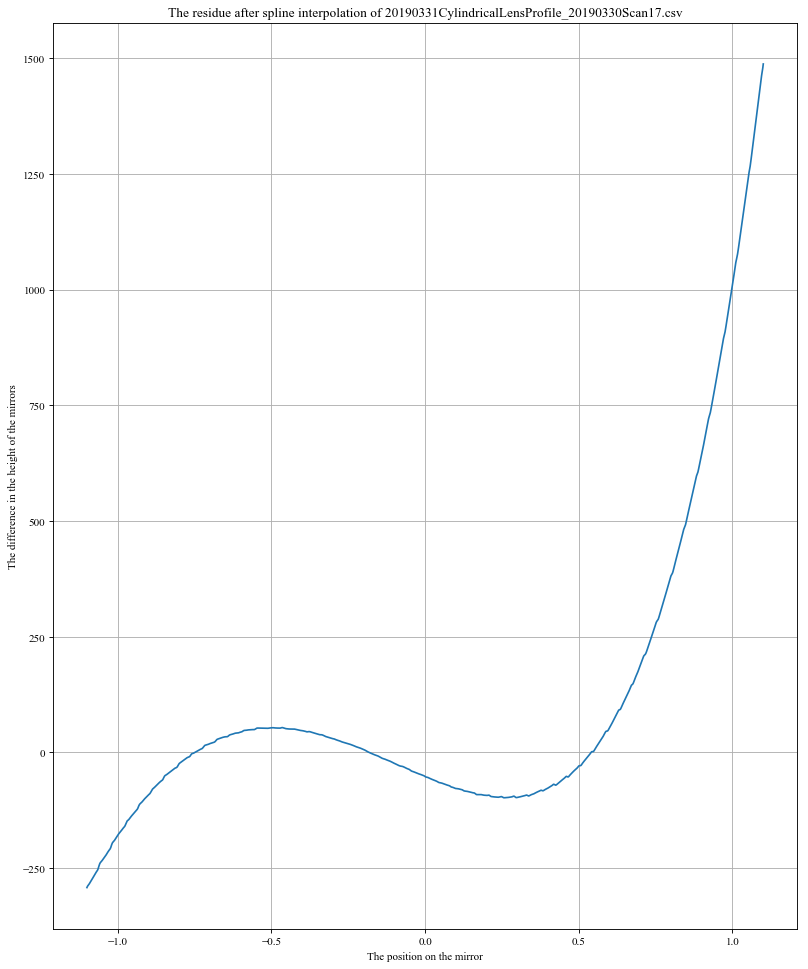

In [26]:
plt.figure(figsize=(12, 15), dpi=80)
plt.rcParams["font.size"] = 10
for i in range(len(filename)):
    plt.subplot(len(filename),1,i+1)
    x_i = "x{}".format(i)
    y_i = "y{}".format(i)
    plt.plot(mir_residue[x_i], SplineResidue[i](mir_residue[x_i]))
    plt.title("The residue after spline interpolation of {}".format(filename[i]))
    plt.xlabel("The position on the mirror")
    plt.ylabel("The difference in the height of the mirrors")
    plt.grid(True)

In [27]:
plt.figure(figsize=(15, 10), dpi=80)
plt.rcParams["font.size"] = 10
for i in range(len(filename)-1):
    plt.subplot(len(filename)-1,1,i+1)
    plt.plot(mir_residue["x{}".format(i)], SplineSurface[i+1](mir_residue["x{}".format(i)])-SplineSurface[i](mir_residue["x{}".format(i)]))
    plt.title("The change in spline interpolation before and after")
    plt.xlabel("The position on the mirror")
    plt.ylabel("The difference in the height of the mirrors")
    plt.grid(True)

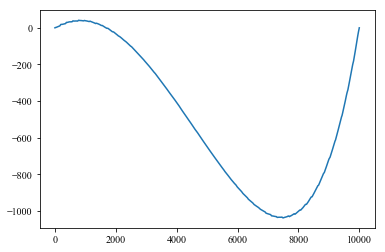

In [28]:
# remove the plane component 
tilt = pd.DataFrame([])
plane_comp = pd.DataFrame([])
residue_plane_removed = pd.DataFrame([])

for i in range(len(filename)):
    x_i = "x{}".format(i)
    y_i = "y{}".format(i)
    tilt = (mir_residue[y_i][N-1] - mir_residue[y_i][0]) / (mir_residue[x_i][N-1] - mir_residue[x_i][0])
    plane_comp = pd.DataFrame([tilt * (mir_residue[x_i][j] - mir_residue[x_i][0]) + mir_residue[y_i][0] for j in range(N)])
    residue_plane_removed = pd.concat([residue_plane_removed, pd.DataFrame(mir_residue[y_i].values - plane_comp.unstack().values)], axis=1)
residue_plane_removed.columns = [i for i in range(len(filename))]
plt.plot(residue_plane_removed)

In [29]:
residue_plane_removed = pd.DataFrame([])
for i in range(len(filename)):
    x_i = "x{}".format(i)
    y_i = "y{}".format(i)
    res1 = np.polyfit(mir_residue[x_i],mir_residue[y_i],1)
    residue_plane_removed = pd.concat([residue_plane_removed, pd.DataFrame(mir_residue[y_i] - np.poly1d(res1)(mir_residue[x_i]))], axis=1)


1326.0323250637753


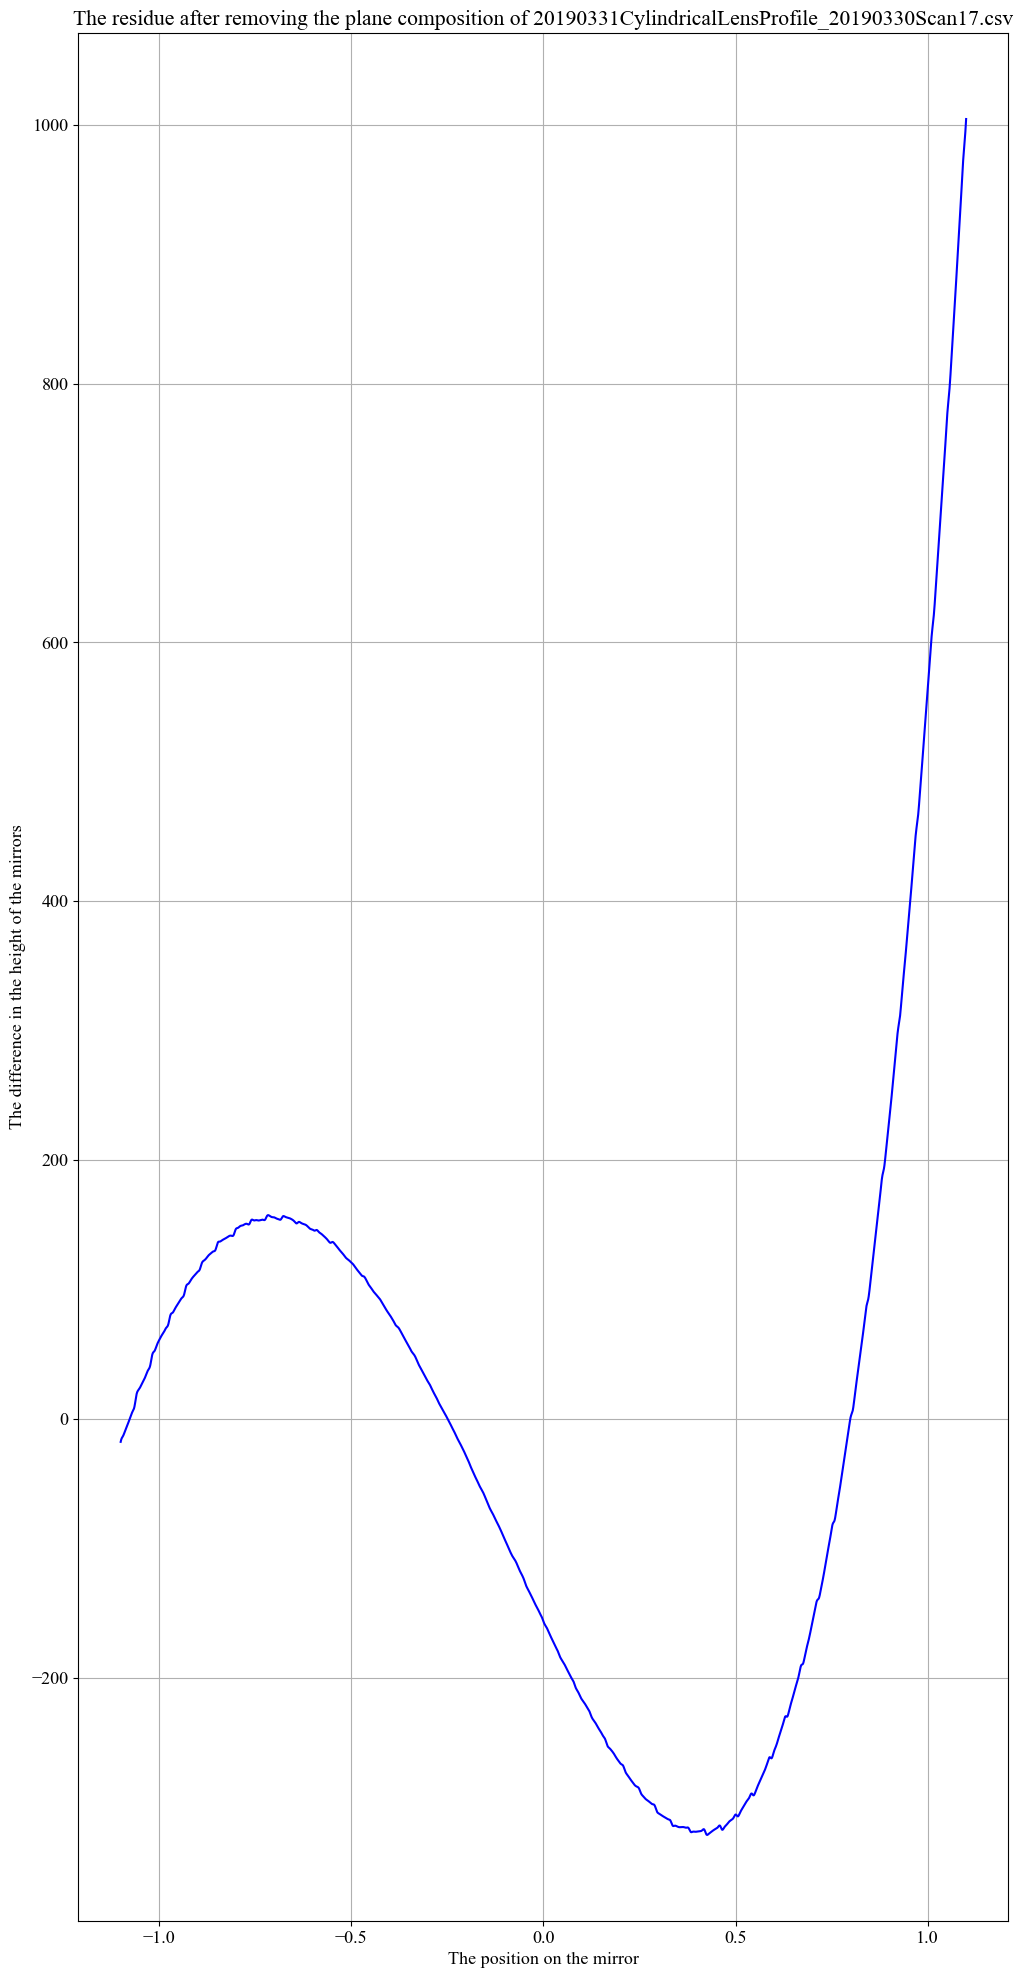

In [30]:
plt.figure(figsize=(12, 25), dpi=100)
plt.rcParams["font.size"] = 13
plt.rcParams['font.family'] = 'Times New Roman'
for i in range(len(filename)):
    plt.subplot(len(filename),1,i+1)
    x_i = "x{}".format(i)
    y_i = "y{}".format(i)
    plt.plot(mir_residue[x_i], residue_plane_removed[y_i],color='b')
    plt.title("The residue after removing the plane composition of {}".format(filename[i]))
    plt.xlabel("The position on the mirror")
    plt.ylabel("The difference in the height of the mirrors")
    plt.grid(True)
    print(residue_plane_removed[y_i].max() - residue_plane_removed[y_i].min())

1326.0323250637753


KeyError: 'x1'

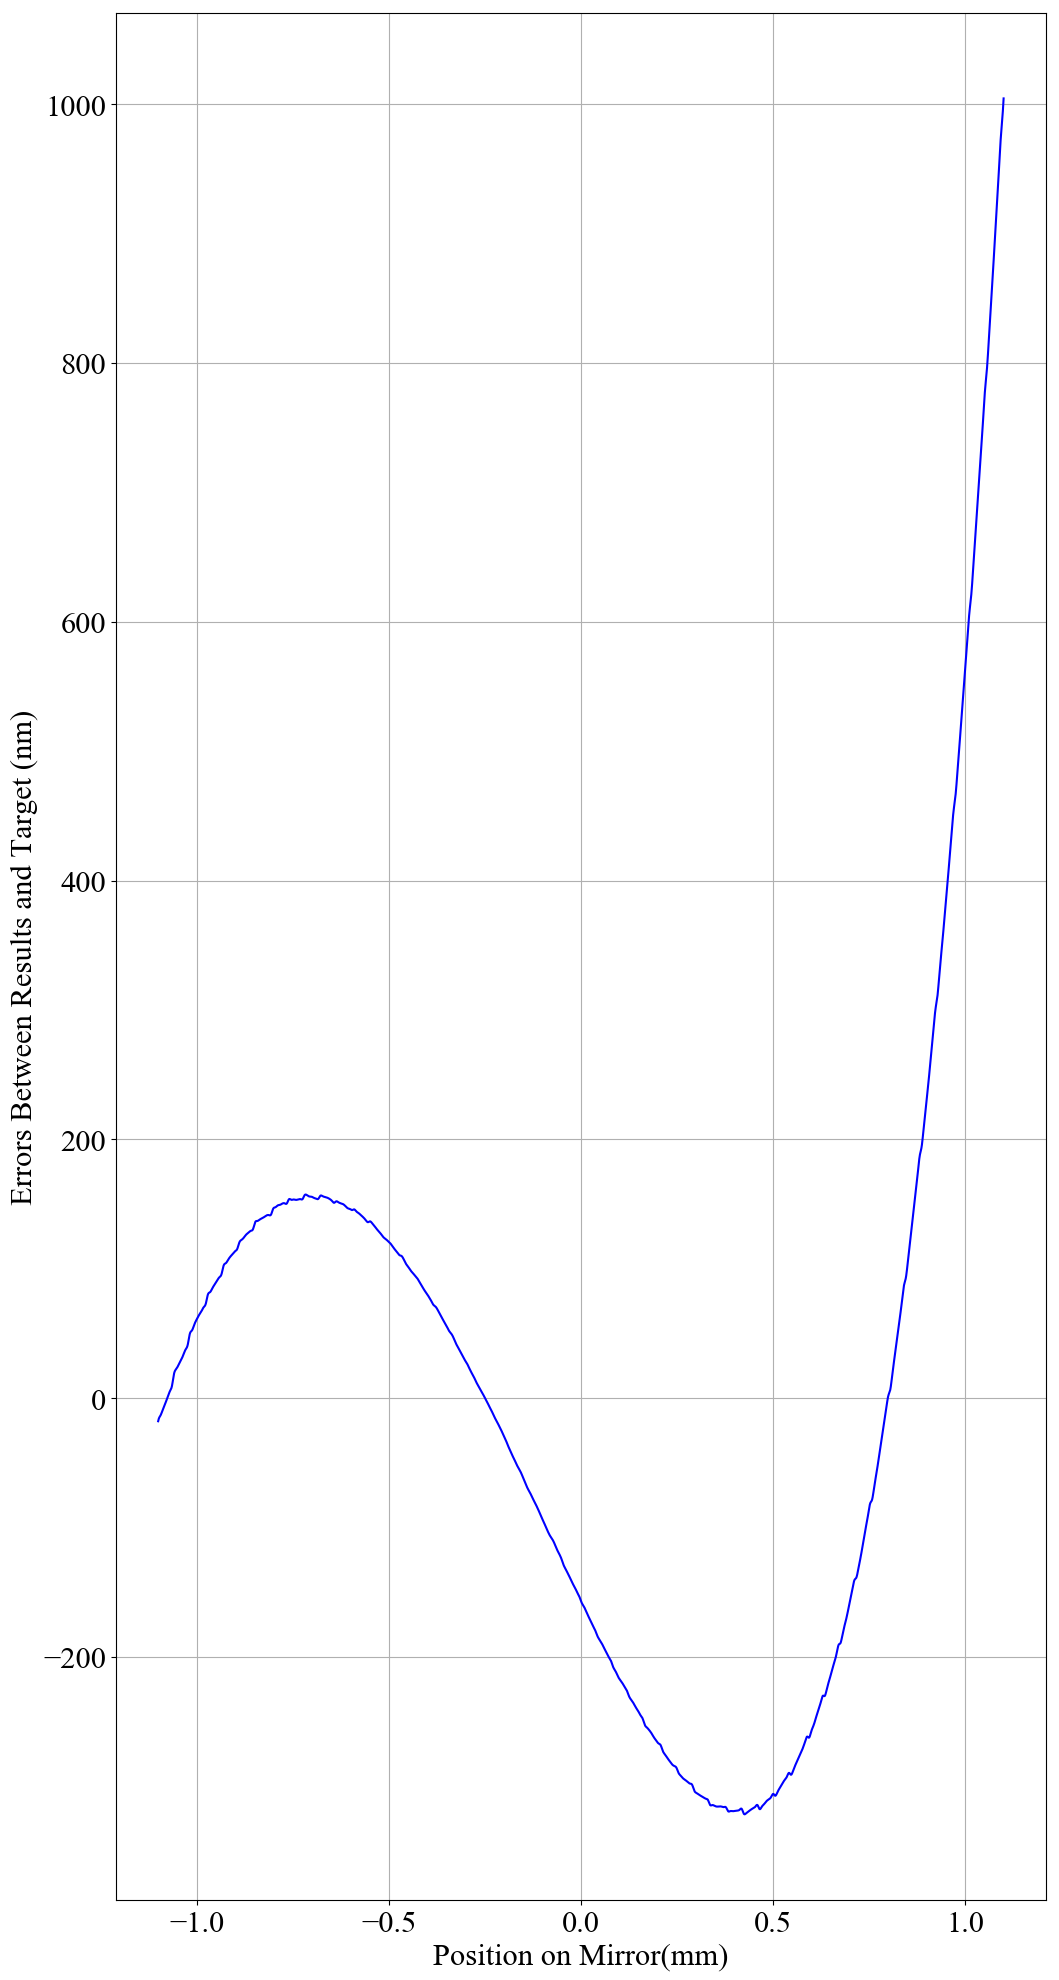

In [31]:
plt.figure(figsize=(12, 25), dpi=100)
plt.rcParams["font.size"] = 22
plt.rcParams['font.family'] = 'Times New Roman'
for i in range(len(filename)):
    plt.subplot(len(filename),1,i+1)
    x_i = "x{}".format(i)
    y_i = "y{}".format(i)
    plt.plot(mir_residue[x_i], residue_plane_removed[y_i],color='b')
    #plt.title("Results from Sputtering {} Time(s)".format(i+1))
    plt.xlabel("Position on Mirror(mm)")
    plt.ylabel("Errors Between Results and Target (nm)")
    #plt.ylim([-12,12])
    plt.grid(True)
    print(residue_plane_removed[y_i].max() - residue_plane_removed[y_i].min())

#i=1
#plt.subplot(len(filename),1,i+1)
#x_i = "x{}".format(i)
#y_i = "y{}".format(i)
#plt.plot(mir_residue[x_i], residue_plane_removed[y_i],color='b')
#plt.title("Results from Sputtering {} Time(s)".format(i+1))
#plt.xlabel("Position on Mirror(mm)")
#plt.ylabel("Errors Between Results and Target (nm)")
#plt.ylim([-12,12])
#plt.grid(True)
#print(residue_plane_removed[y_i].max() - residue_plane_removed[y_i].min())    
    
    
now = datetime.datetime.now()
output_filetitle = now.strftime('%Y%m%d') + "Error.csv"
tmp = pd.DataFrame([mir_residue["x1"], residue_plane_removed["y1"]])
tmp.T.to_csv(output_filetitle, sep=',')
tmp.T.head()

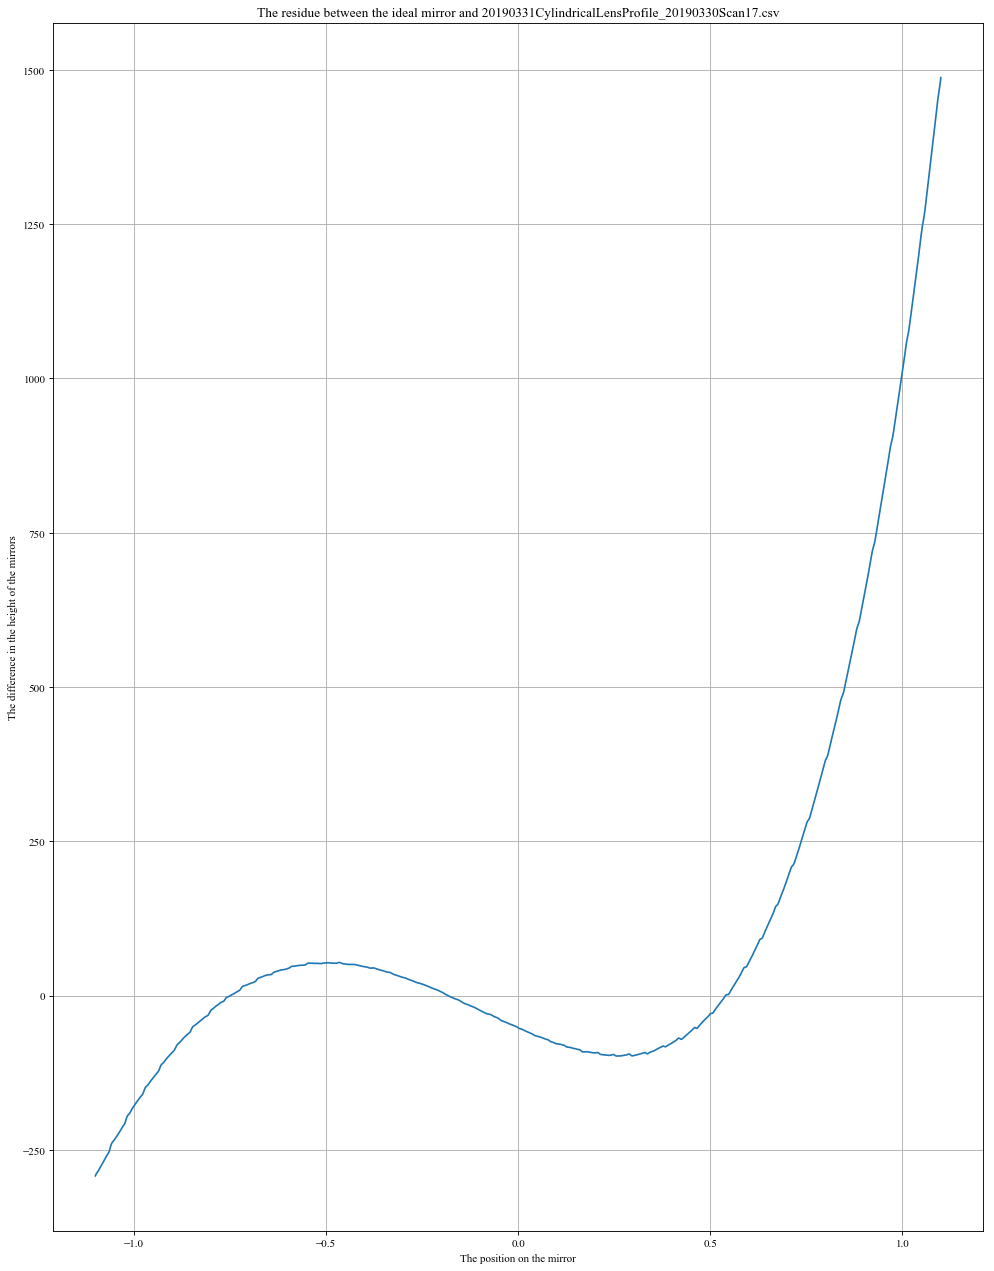

In [32]:
plt.figure(figsize=(15, 20), dpi=80)
plt.rcParams["font.size"] = 10
for i in range(len(filename)):
    plt.subplot(len(filename),1,i+1)
    x_i = "x{}".format(i)
    y_i = "y{}".format(i)
    plt.plot(mir_residue[x_i], mir_residue[y_i])
    plt.title("The residue between the ideal mirror and {}".format(filename[i]))
    plt.xlabel("The position on the mirror")
    plt.ylabel("The difference in the height of the mirrors")
    plt.grid(True)

In [33]:
# output the difference
x_sampling = np.linspace(-0.5*mir_length, 0.5*mir_length, num=int(N_sample), endpoint=False)
x_sampling

array([-1.1               , -1.0995000000000001, -1.0990000000000002, ...,
        1.0985            ,  1.0989999999999998,  1.0995            ])

In [34]:
mir_residue_output = pd.DataFrame([x_sampling + 0.5*mir_length, SplineResidue[0](x_sampling)], index =['x','y']).T
mir_residue_output.x = mir_residue_output.x * 1000
#mir_residue_output.y = mir_residue_output.y - mir_residue_output.y.min() + sputter_offset
mir_residue_output.y = mir_residue_output.y + sputter_offset 

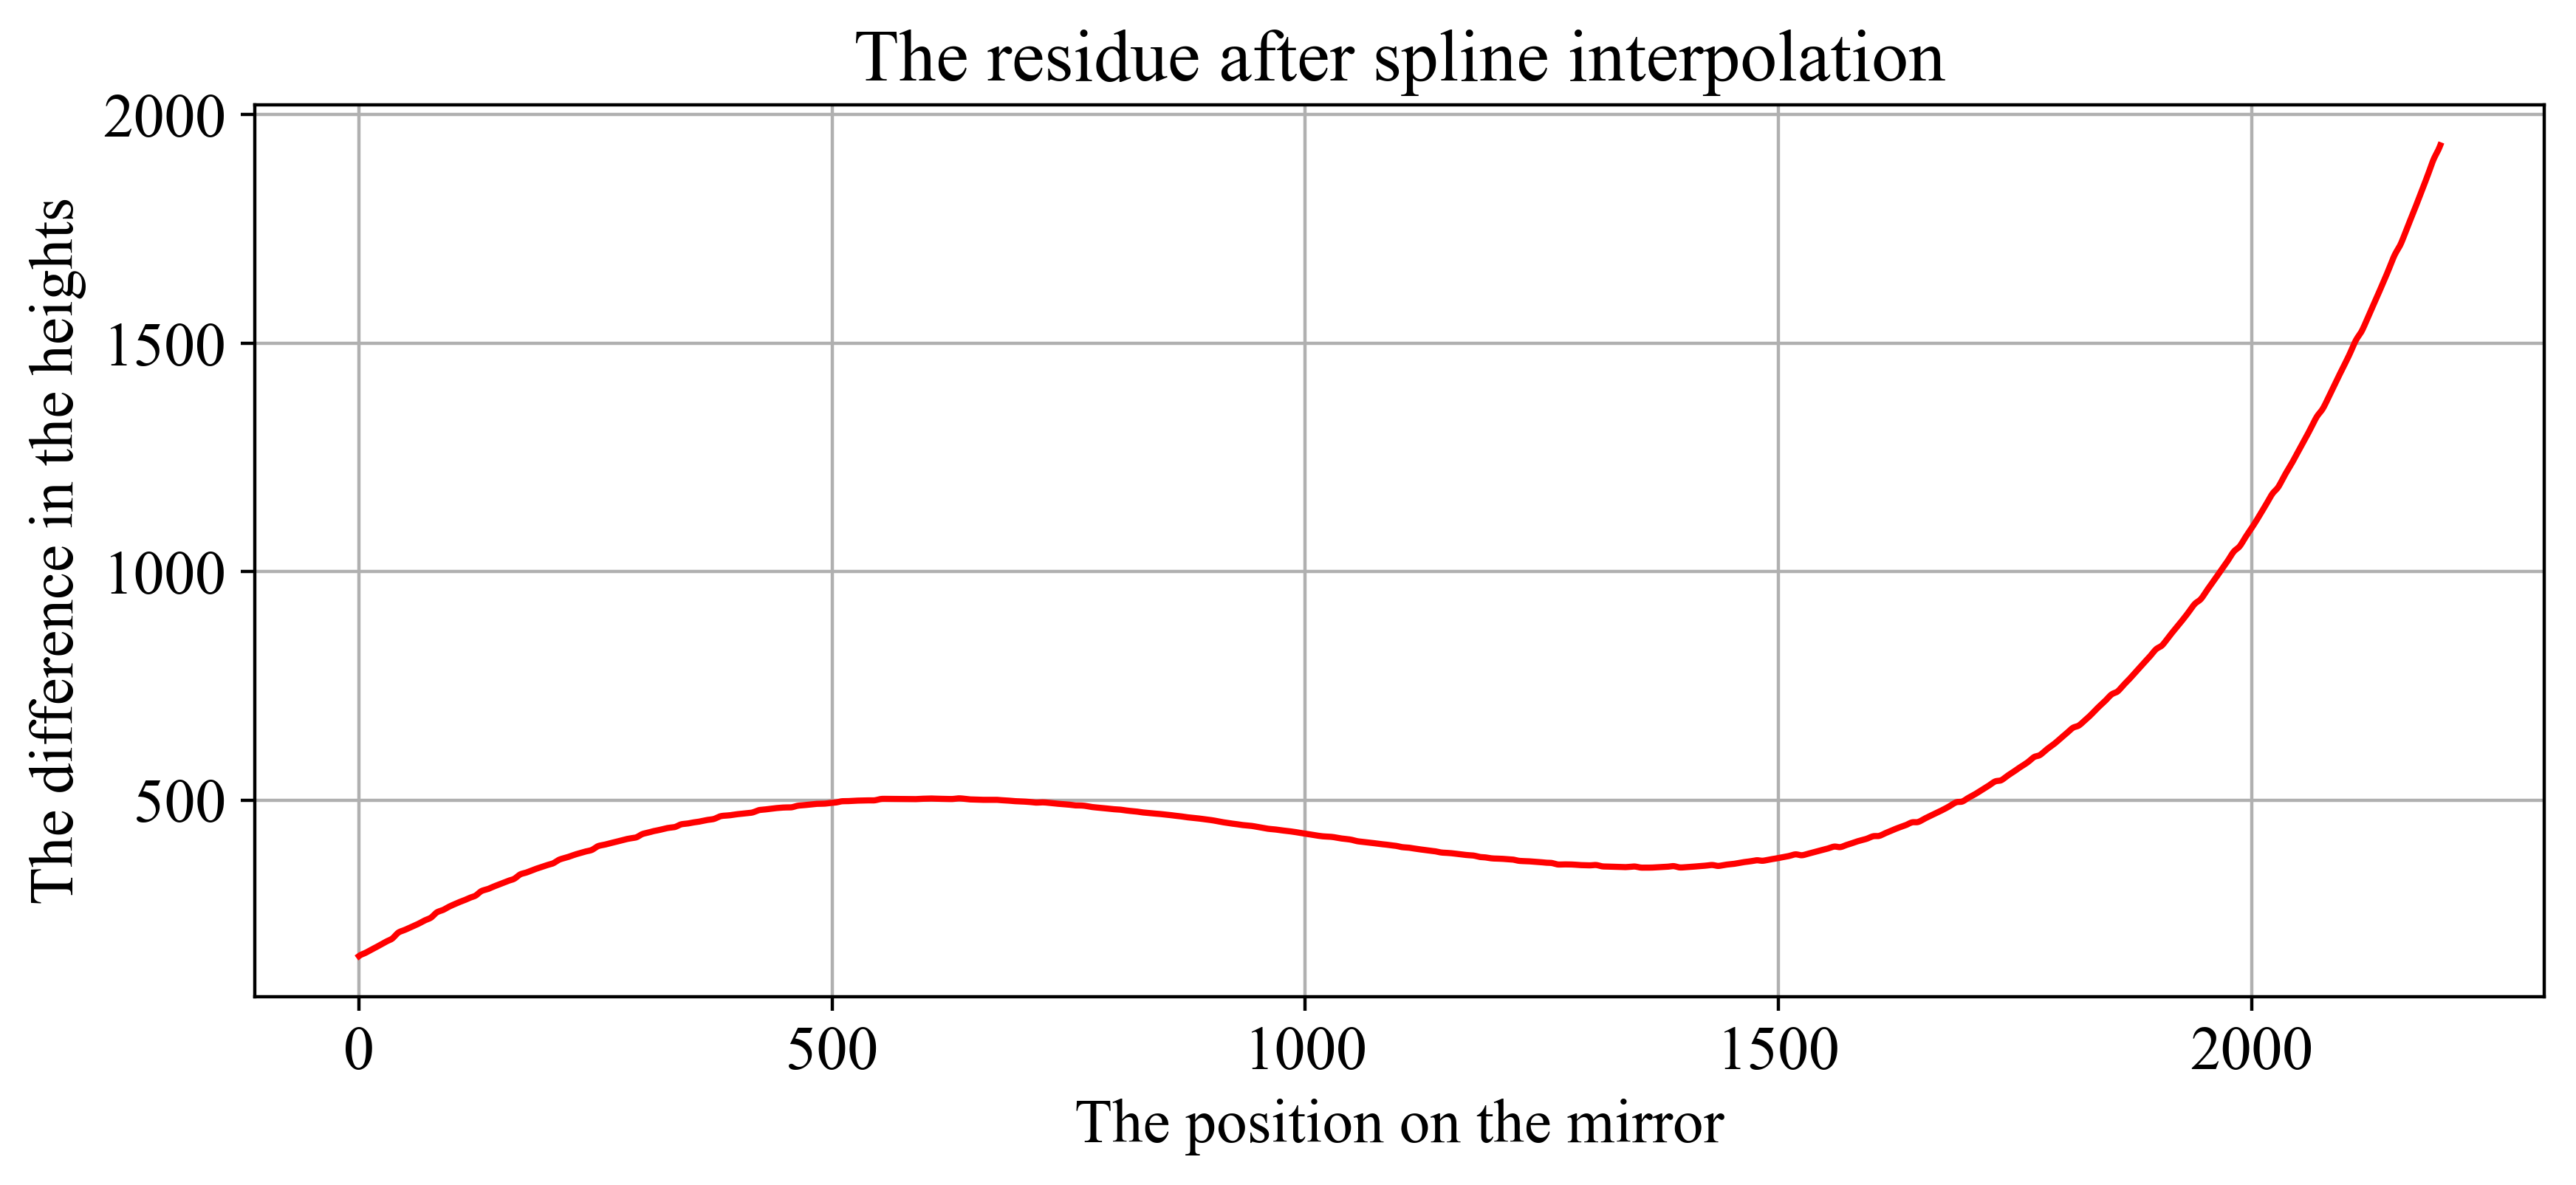

In [35]:
plt.figure(figsize=(10, 4), dpi=400)
plt.rcParams["font.size"] = 15
plt.plot(mir_residue_output.x, mir_residue_output.y, '-', color='r')
plt.title("The residue after spline interpolation")
plt.xlabel("The position on the mirror")
plt.ylabel("The difference in the heights")

plt.grid(True)
plt.show()

In [36]:
now = datetime.datetime.now()
output_filetitle = now.strftime('%Y%m%d') + "ResidueMirrorAndCyl.csv"
output_filetitle

'20190331ResidueMirrorAndCyl.csv'

In [37]:
mir_residue_output.to_csv(output_filetitle, sep=',')

In [ ]:
#rm 20181010ResidueMirrorAndCyl.csv